In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

from quickstats.plots import Likelihood1DPlot, Likelihood2DPlot, UpperLimit3DPlot
from quickstats.utils.common_utils import combine_dict

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
# from scipy.interpolate import interp1d
# def get_interval(df, level):
#     xvalues = df['mu'].to_numpy()
#     yvalues = df['qmu'].to_numpy()
#     func_theory = interp1d(xvalues, yvalues)
#     x_new = np.arange(min(xvalues), max(xvalues), 0.01)
#     y_new = func_theory(x_new)
    
#     asign = np.sign(y_new-level)
#     signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
#     intersections = x_new[signchange==1]
#     return intersections

In [3]:
# df = {}
# df['singleH'] = pd.read_csv('csv_withoutboosthbb_ihep/singleH_scan_kl_only_exp.csv').rename(columns={'k3': 'mu', 'nll': 'qmu'})
# df['HHH'] = pd.read_csv('csv_withoutboosthbb_ihep/HHH_scan_kl_only_exp.csv').rename(columns={'k3': 'mu', 'nll': 'qmu'})


# config = {
#         'sigma_values': (1, 3.84),
#         'sigma_levels': ('1sigma', '0.95'),
#         'sigma_names': ('68%', '95%'),
#         'sigma_pos': 0.89,
#      }
# styles = {
#         'legend': {
#             'loc': (0.7, 0.66)
#         },
#         'plot': {
#             'linewidth': 3,
#         },
# }

# label_options = {
#     'loc': (0.05, 0.96),
#     'fontsize': 25, # ATLAS
#     'energy': '13 TeV',
#     'lumi': r'126—139 fb$^{-1}$',
#     'extra_text': r'$m_H=$125.09 GeV//Expected'
# }
# anno_op = {
#     'x': 0.3,
#     'y': 0.67,
#     'dy': 0.065,
#     'font_size': 19
# }

# plotter = Likelihood1DPlot(df, styles=styles, config = config, analysis_label_options=label_options)
# ymin=0
# ymax=10
# xmin=-8
# xmax=16
# xlabel=r"$\mathrm{\kappa_{\lambda}}$"
# ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, )

# intersections_1 = get_interval(df, 1).tolist()
# intersections_2 = get_interval(df, 3.84).tolist()
# ax.annotate(r'Combined:', 
#             (anno_op['x'], anno_op['y']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
# ax.annotate(r'$68\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
#             (anno_op['x'], anno_op['y'] - anno_op['dy']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])
# ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
#             (anno_op['x'], anno_op['y'] - 2 * anno_op['dy']), xycoords = 'axes fraction', fontsize = anno_op['font_size'])

## 2D

In [4]:
from quickstats.maths.numerics import is_integer, pretty_value

def read():
    df_2D = {'exp': {}, 'obs': {}}
    df_2D['exp']['HHH'] = pd.read_csv('csv_withoutboosthbb_ihep/HHH_k3VSkt_Exp.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['HHH'] = pd.read_csv('csv_withoutboosthbb_ihep/HHH_k3VSkt_Obs.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['exp']['singleH'] = pd.read_csv('csv_withoutboosthbb_ihep/singleH_k3VSkt_Exp.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['singleH'] = pd.read_csv('csv_withoutboosthbb_ihep/singleH_k3VSkt_Obs.csv').rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['exp']['diHiggs'] = pd.read_json('../outputs_HHH2022_20220520_with_BR_decorrelation/likelihood/expected/combined/klambda_kt_2D/klambda_kt.json') #.rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    df_2D['obs']['diHiggs'] = pd.read_json('../outputs_HHH2022_20220520_with_BR_decorrelation/likelihood/observed/combined/klambda_kt_2D/klambda_kt.json') #.rename(columns={'k3': 'klambda', 'nll': 'qmu'})
    cut = 1.38
    df_2D['exp']['diHiggs'] = df_2D['exp']['diHiggs'].drop(df_2D['exp']['diHiggs'][df_2D['exp']['diHiggs']['kt']>cut].index)
    df_2D['obs']['diHiggs'] = df_2D['obs']['diHiggs'].drop(df_2D['obs']['diHiggs'][df_2D['obs']['diHiggs']['kt']>cut].index)
    df_2D['obs']['diHiggs'].apply(pretty_value)

    return df_2D

df_2D = read()
df_2D['obs']['diHiggs'].head(5)

,nll,qmu,klambda,kt
0,756931.644199,0.000000,1.218414,0.127581
1,757038.640027,213.991656,-15.000000,-2.000000
2,757037.247149,211.205900,-15.000000,-1.800000
3,757034.071121,204.853843,-15.000000,-1.600000
4,757028.722881,194.157364,-15.000000,-1.400000


In [27]:
plt.__file__

'/Users/zhangrui/opt/anaconda3/envs/roopy38/lib/python3.8/site-packages/matplotlib/pyplot.py'

In [89]:
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Tex Gyre Heros', 'Helvetica', 'Nimbus Sans', 'Arial']})

def plot_klambda_kt(df, obs):
    df_2D = df[obs]
#     labels = {
#         'exp': r'$m_H=$125.09 GeV//All other $\mathrm{\kappa}$'+'\'s fixed to SM//Expected',
#         'obs': r'$m_H=$125.09 GeV//All other $\mathrm{\kappa}$'+'\'s fixed to SM//Observed',
#     }
    labels = {
        'exp': r'All other $\mathrm{\kappa_{\lambda}}$'+' fixed to SM//Expected',
        'obs': r'All other $\mathrm{\kappa_{\lambda}}$'+' fixed to SM//Observed',
    }
    save = {
        'exp': 'H_HH_HHH_kl_kt_2D_asimov_internal.pdf',
        'obs': 'H_HH_HHH_kl_kt_2D_data_internal.pdf',
    }
    label_options = {
        'colab': r'$\textbf{\textit{ATLAS}}$',
        'status': "prelim",
        'loc': (0.05, 0.96),
        'fontsize': 25, # ATLAS
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'extra_text': labels[obs],
    }
    config_map = {
        'HHH': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': ('68\% CL HH+H', '95\% CL HH+H'),
            'sigma_colors': ('k', 'k'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'linear',
            'num_grid_points': 70,
        },
        'singleH': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': ('68\% CL H', '95\% CL H'),
            'sigma_colors': ('b', 'b'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 30,
        },
        'diHiggs': {
            'sigma_levels': ('0.68', '0.95'),
            'sigma_names': ('68\% CL HH', '95\% CL HH'),
            'sigma_colors': ('r', 'r'),
            'sigma_linestyles': ('solid', 'dashed'),
            'interpolation': 'cubic',
            'num_grid_points': 50,
        },
     }
    styles = {
        'legend': {
            'loc': (0.67, 0.52),
            'prop': {'size': 17},
        },
        'plot': {
            'linewidth': 3,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'axis': {
            'labelsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        }
    }

    styles_map = {
        'singleH': {"color": 'b', "marker": ","},
        'HHH': {"color": "#9A0EEA", "marker": ","},
        'diHiggs': {"color": "#008F00", "marker": ","},
    }
    label_map = {
        'singleH': 'H',
        'HHH': 'HH+H',
        'diHiggs': 'HH',
    }

    x='klambda'
    y='kt'
    xlabel=r"$\mathrm{\kappa_{\lambda}}$"
    ylabel=r"$\mathrm{\kappa_{t}}$"
    best_fit_x, best_fit_y = {}, {}

    # plotter = Likelihood2DPlot(data_map=df_2D['singleH'], styles=styles, config = config['singleH'], analysis_label_options=label_options)
    # best_fit_x['singleH'] = df_2D['singleH'][x].iloc[df_2D['singleH']['qmu'].idxmin()]
    # best_fit_y['singleH'] = df_2D['singleH'][y].iloc[df_2D['singleH']['qmu'].idxmin()]
    # print(best_fit_x)
    # plotter.add_highlight(1, 1, label="SM prediction")
    # plotter.add_highlight(best_fit_x['singleH'], best_fit_y['singleH'], label=f"Best fit single H({best_fit_x['singleH']:.2f}, {best_fit_y['singleH']:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })
    # ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)

    show_colormesh=True
    ymin=0.86
    ymax=1.4
    xmin=-10
    xmax=20

    plotter = Likelihood2DPlot(data_map=df_2D, styles_map=styles_map, label_map=label_map, styles=styles, config_map=config_map, analysis_label_options=label_options)
    plotter.add_highlight(1, 1, label="SM prediction", styles={'markerfacecolor':'k', 'color':'k', 'marker':(5, 1, 180), 'linestyle': None, 'linewidth': 0, 'markersize': 20})
    for k in df_2D:
        best_fit_x[k] = df_2D[k][x].iloc[df_2D[k]['qmu'].idxmin()]
        best_fit_y[k] = df_2D[k][y].iloc[df_2D[k]['qmu'].idxmin()]
    print(best_fit_x, best_fit_y['HHH'])
    # plotter.add_highlight(best_fit_x['HHH'], best_fit_y['HHH'], label=f"Best fit HH+H({best_fit_x['HHH']:.2f}, {best_fit_y['HHH']:.2f})", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, })
    plotter.add_highlight(best_fit_x['HHH'], best_fit_y['HHH'], label=f"Best fit HH+H", styles={'marker': 'P', 'linewidth': 0, 'markersize': 15, 'markerfacecolor':'w' })
    ax = plotter.draw(xattrib=x, yattrib=y, xlabel=xlabel, ylabel=ylabel, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, show_colormesh=show_colormesh)
    savefolder = 'figures/'
    os.makedirs(savefolder, exist_ok=True)
    plt.savefig(savefolder + save[obs], bbox_inches="tight")

{'HHH': 3.0, 'singleH': 2.5, 'diHiggs': 1.218414243084705} 1.0
{'HHH': 1.0, 'singleH': 1.0, 'diHiggs': 1.000001822063227} 1.0


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

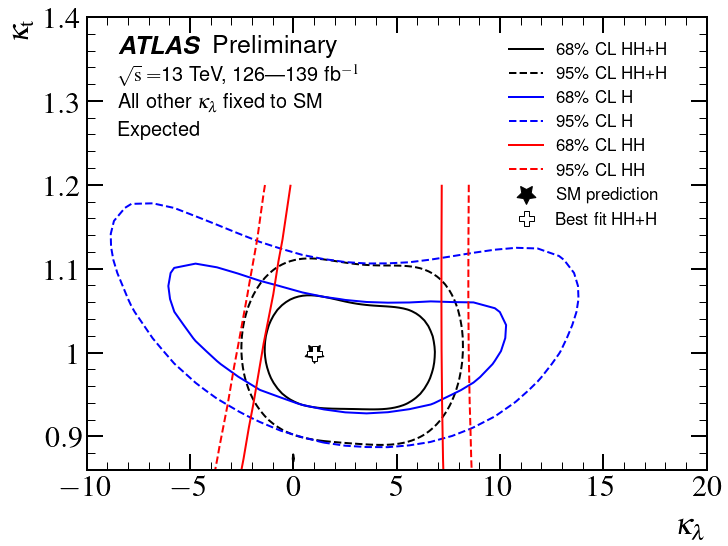

In [90]:
plot_klambda_kt(df_2D, 'obs')
plot_klambda_kt(df_2D, 'exp')

## Correlation check

In [52]:
file_path = '/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/correlation'
asimov = pd.read_json(f'{file_path}/bbtautau_asimov.json')['klambda']
obs = pd.read_json(f'{file_path}/bbtautau_obs.json')['klambda']

In [55]:
diff = asimov - obs

In [59]:
largeindex = diff[abs(diff) > 0.05].index

In [61]:
asimov[largeindex], obs[largeindex]

(k2V                                         0.424296
 alpha_THEO_XS_SCALEMTop_ggFSMHH             0.073535
 alpha_THEO_ACC_HF_ggFH                      0.265602
 alpha_SysTHEO_ACC_Zhf_SCALE                 0.092870
 alpha_SysTHEO_ACC_Zhf_GENERATOR            -0.047171
 alpha_SysTHEO_ACC_StopWt_TopInterference   -0.187157
 Name: klambda, dtype: float64,
 k2V                                        -0.105039
 alpha_THEO_XS_SCALEMTop_ggFSMHH             0.002915
 alpha_THEO_ACC_HF_ggFH                      0.019685
 alpha_SysTHEO_ACC_Zhf_SCALE                -0.006337
 alpha_SysTHEO_ACC_Zhf_GENERATOR             0.024541
 alpha_SysTHEO_ACC_StopWt_TopInterference   -0.042872
 Name: klambda, dtype: float64)

In [40]:
best_fit_path = '/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220520_with_BR_decorrelation/correlation/bestfit_scan/'
channels = ['bbyy', 'bbtautau', 'bbbb']
df = {}
for chan in channels:
    df[chan] = {}
    for experiment in ['exp', 'obs']:
        df[chan][experiment] = pd.read_json(f'{best_fit_path}/{chan}/klambda_k2V_{experiment}/klambda_k2V.json')
        df[chan][experiment] = pd.read_json(f'{best_fit_path}/{chan}/klambda_k2V_{experiment}/klambda_k2V.json')

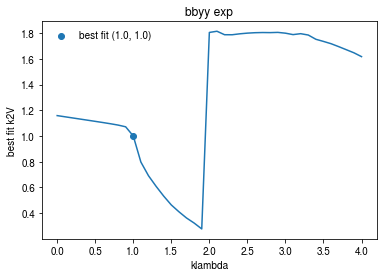

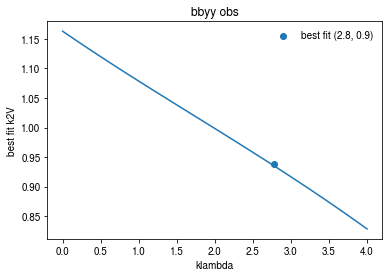

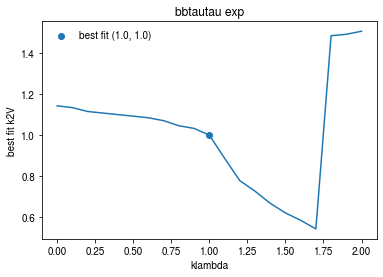

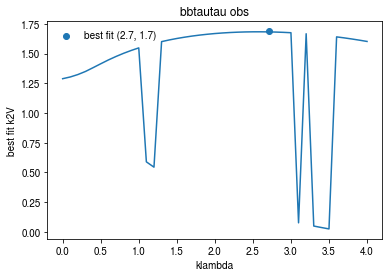

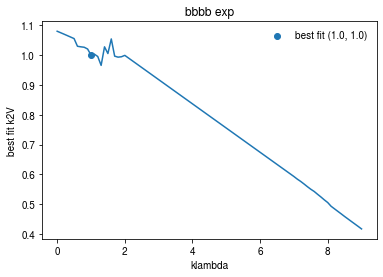

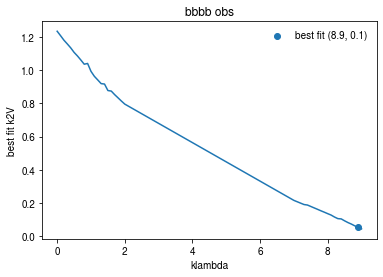

In [41]:
x, y ='klambda', 'k2V'
for chan in channels:
    for experiment in ['exp', 'obs']:
        df_nobest = df[chan][experiment].iloc[1: , :]
        df_best = df[chan][experiment].iloc[0:1, :]
        plt.plot(df_nobest[x], df_nobest[y])
        plt.scatter(df_best[x][0], df_best[y][0], label='best fit (%.1f, %.1f)'%(df_best[x][0], df_best[y][0]))
        plt.title(chan+' '+experiment)
        plt.xlabel(x)
        plt.ylabel(f'best fit {y}')
        plt.legend()
        plt.show()